In [1]:
import medmnist
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim 
import torch.utils.data as data
import torchvision.transforms as transforms

from medmnist import INFO, Evaluator
from tqdm import tqdm

from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import AerPauliExpectation
from qiskit_aer import Aer
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

from qpie import QPIE
from neqr import NEQR

from skimage.transform import resize
import torch.nn.functional as F

In [2]:
flags = ["pathmnist", 
         "octmnist", 
         "pneumoniamnist",
         "chestmnist",
         "dermamnist",
         "retinamnist",
         "breastmnist",
         "bloodmnist",
         "tissuemnist",
         "organcmnist",
         "organsmnist",
         "organmnist3d",
         "nodulemnist3d",
         "adrenalmnist3d",
         "fracturemnist3d",
         "vesselmnist3d",
         "synapsemnist3d"]

In [3]:
NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

In [4]:
data_flag = flags[2]
info = INFO[data_flag]
task = info["task"]
n_channel = info["n_channels"]
n_classes = len(info["label"])

DataClass = getattr(medmnist, info["python_class"])

In [5]:
data_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(mean=[.5], std=[.5])])

train_dataset = DataClass(split='train', transform=data_transform)
test_dataset = DataClass(split='test', transform=data_transform)

In [6]:
len(train_dataset.imgs)

4708

In [7]:
train_dataset.imgs.shape

(4708, 28, 28)

In [8]:
train_dataset.imgs[0].shape

(28, 28)

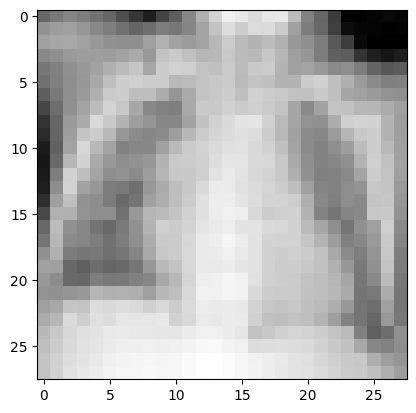

In [9]:
plt.imshow(train_dataset.imgs[0], cmap="gray")
plt.show()

In [10]:
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

In [11]:
class Net(nn.Module):
    
    def __init__(self, in_channels, num_classes) -> None:
        super(Net, self).__init__()
        
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=3),
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
                                    nn.BatchNorm2d(16),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer3 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        self.layer4 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        self.layer5 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fc = nn.Sequential(nn.Linear(64 * 4 * 4, 128),
                                nn.ReLU(),
                                nn.Linear(128, 128),
                                nn.ReLU(),
                                nn.Linear(128, num_classes))
        
    def forward(self, x):
            
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
            
        return x    

In [12]:
model = Net(in_channels=n_channel, num_classes=n_classes)

if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.Adam(model.parameters(), lr=lr)
# optimizer = optim.LBFGS(model.parameters(), lr=lr)

In [15]:
for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

100%|██████████| 37/37 [00:03<00:00, 11.53it/s]


In [16]:
def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

In [17]:
print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
train  auc: 0.509  acc:0.600
test  auc: 0.965  acc:0.912


In [5]:
algorithm_globals.random_seed = 42
qi = QuantumInstance(backend=Aer.get_backend("statevector_simulator"))
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
def create_qnn():
    feature_map = ZZFeatureMap(2)
    ansatz = RealAmplitudes(2, reps=1)
    qnn = TwoLayerQNN(2, 
                      feature_map=feature_map,
                      ansatz=ansatz,
                      input_gradients=True,
                      exp_val=AerPauliExpectation(),
                      quantum_instance=qi)
    return qnn

In [7]:
from torch import cat

In [8]:
class HybridNet(nn.Module):
    
    def __init__(self, qnn):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 2, kernel_size=5)
        self.conv2 = nn.Conv2d(2, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 2)  # 2-dimensional input to QNN
        self.qnn = TorchConnector(qnn)  # Apply torch connector, weights chosen
        # uniformly at random from interval [-1,1].
        self.fc3 = nn.Linear(1, 1)  # 1-dimensional output from QNN

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)  # apply QNN
        x = self.fc3(x)
        return cat((x, 1 - x), -1)    

In [9]:
qnn = create_qnn()

In [10]:
model4 = HybridNet(qnn)

In [11]:
data_transform = transforms.Compose([transforms.ToTensor()])

train_dataset = DataClass(split='train', transform=data_transform)
test_dataset = DataClass(split='test', transform=data_transform)

train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

In [16]:
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

In [17]:
for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model4.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model4(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

100%|██████████| 37/37 [16:47<00:00, 27.22s/it]


In [20]:
def test(split):
    model4.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model4(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc: %.3f' % (split, *metrics))

In [21]:
print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
train  auc: 0.488  acc:0.742
test  auc: 0.895  acc:0.625
